In [1]:
import os
import sys

In [2]:
%matplotlib inline

from matplotlib import rc
import matplotlib.pyplot as plt 
from matplotlib.pyplot import imshow, quiver

In [3]:
import scipy
from scipy import ndimage as ndi
import networkx as nx

In [4]:
import numpy as np
from numpy.random import randn

In [24]:
import astromorpho as astro

/home/levtg/astro-morpho/venv/lib64/python3.10/site-packages/imfun/external/tifffile.py:7261: UserWarning: No module named 'imfun.external._tifffile'
  Functionality might be degraded or be slow.

  warnings.warn("%s%s" % (e, warn))
/home/levtg/astro-morpho/venv/lib64/python3.10/site-packages/imfun/external/czifile.py:146: UserWarning: ImportError: No module named '_czifile'. Decoding of JXR and JPEG encoded images will not be available. Czifile.pyx can be obtained at http://www.lfd.uci.edu/~gohlke/
  warnings.warn(


# Тестовая картинка

Линии

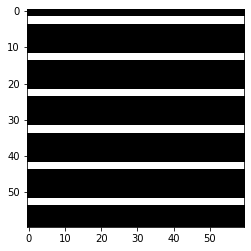

In [6]:
img_lines = np.zeros((100,100))
img_lines[2::10] = 1
img_lines[3::10] = 1
img_lines = img_lines[20:-20,20:-20]

img_lines = np.clip(img_lines, 0, 1)
crop = (slice(20,-20), slice(20,-20))
img = img_lines
imshow(img, cmap='gray')

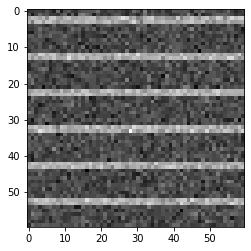

In [7]:
SNR = 5
img_noisy = SNR*img + randn(*img.shape)
imshow(img_noisy, cmap='gray')

Сетка

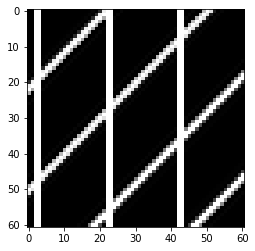

In [8]:
img_lines = np.zeros((100,100))
img_lines[2::20] = 1
img_lines[3::20] = 1
img_lines = ndi.rotate(img_lines, 45)

img_lines[..., 2::20] = 1
img_lines[..., 3::20] = 1

img_lines = img_lines[20:-20,20:-20]

img_lines = np.clip(img_lines, 0, 1)
crop = (slice(20,-20), slice(20,-20))
img = img_lines[crop]
imshow(img, cmap='gray')

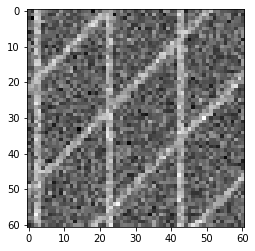

In [9]:
SNR = 3
img_noisy = SNR*img + randn(*img.shape)
imshow(img_noisy, cmap='gray')

Повернутый крест

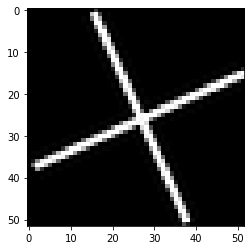

In [13]:
img_cross = np.zeros((100,100))
img_cross[50:52, 23:78] = 1
img_cross[23:78,50:52] = 1
img_cross = ndi.rotate(img_cross, 24)
img_cross = img_cross[20:-20,20:-20]

img_cross = np.clip(img_cross, 0, 1)
crop = (slice(20,-20), slice(20,-20))
img = img_cross[crop]
imshow(img, cmap='gray', interpolation='nearest')

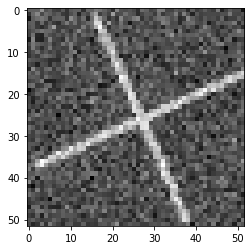

In [14]:
SNR = 5
img_noisy = SNR*img + randn(*img.shape)
imshow(img_noisy, cmap='gray',interpolation='nearest')

Спираль

In [12]:
from PIL import Image

pic = Image.open("/home/incredible/Neuroscience/Code/data/test_images/spiral.png").convert('L')
img = np.clip(np.asarray(pic), 0, 1)
imshow(img, cmap='gray')

FileNotFoundError: [Errno 2] No such file or directory: '/home/incredible/Neuroscience/Code/data/test_images/spiral.png'

In [ ]:
SNR = 5
img_noisy = img*SNR + randn(*img.shape)
imshow(img_noisy, cmap='gray')

Астроцит (типа)

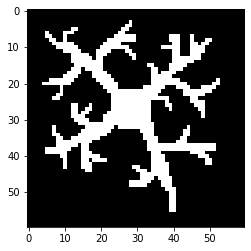

In [152]:
from PIL import Image

pic = Image.open("/home/incredible/Neuroscience/Code/data/test_images/astro.png").convert('L')
img = np.clip(np.asarray(pic), 0, 1)
imshow(img, cmap='gray')

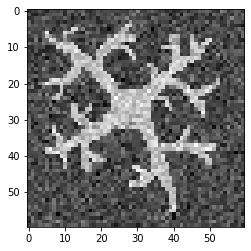

In [153]:
SNR = 5
img_noisy = img*SNR + randn(*img.shape)
imshow(img_noisy, cmap='gray')

Астроцит (реальный)

## Фильтрация изображения

In [17]:
from skimage.filters import threshold_li
from skimage.morphology import remove_small_objects

In [18]:
li = threshold_li(img_noisy)

In [19]:
clear_img = np.where(img_noisy > li, img_noisy, 0)
clearest_img = remove_small_objects(img_noisy >= li, 5, connectivity=3)
final_image = np.where(clearest_img, clear_img, 0)

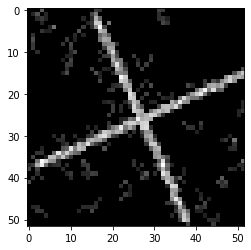

In [20]:
imshow(final_image, cmap='gray')

# Вектора Гессе

In [21]:
sigma = 2

In [25]:
sato, Vf = astro.hessian.sato2d(final_image, sigma, hessian_variant='gradient_of_smoothed', return_vectors=True)

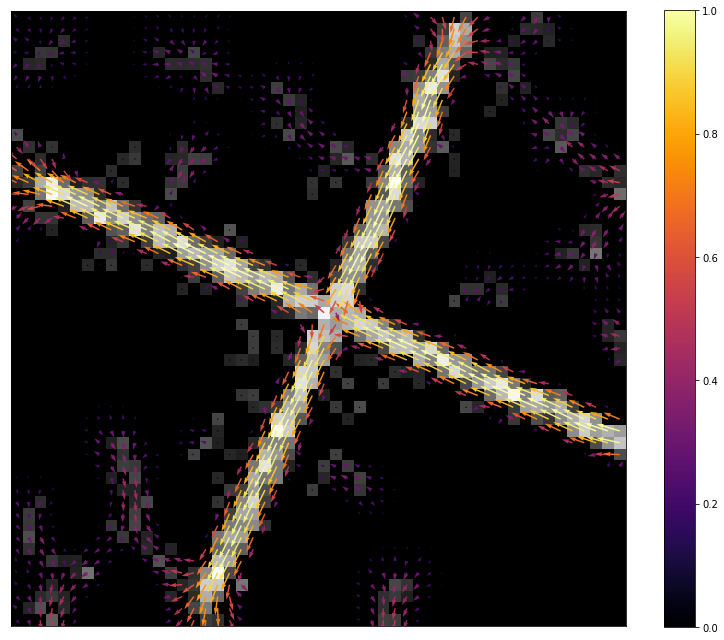

In [27]:
plt.figure(figsize=(11,9))
imshow(final_image, cmap='gray', origin='lower')

weights = astro.enh.percentile_rescale(sato)**0.5

i = 0
Vfx = Vf[...,i][...,::-1]

V = Vfx[...,0] # row directions (Y)
U = Vfx[...,1] # col directions (X)
plt.setp(plt.gca(), xticks=[], yticks=[])
h = quiver(U*weights, V*weights, weights, scale=25, cmap='inferno')
plt.colorbar(h, ax=plt.gca())
plt.tight_layout()

# Построение графа ветвей

В качестве веса ребер будем брать косинусное расстояние между ними

x, y, vectors, weights, img_noisy

In [28]:
lengths = hcecp.percentile_rescale(sato)**0.5

In [29]:
vectors = np.stack((U*lengths, V*lengths), axis=2)

In [30]:
nr, nc = (1, U.shape[0]) if U.ndim == 1 else U.shape
x, y = np.meshgrid(np.arange(nc), np.arange(nr))

In [31]:
def weight_of(a, b):
    try:
        cos_dist = scipy.spatial.distance.cosine(a, b)
    except:
        cos_dist = 0
    return np.abs(1 - cos_dist) * np.mean([np.linalg.norm(a), np.linalg.norm(b)])

In [32]:
k_h, k_w = 3, 3

In [88]:
G = nx.Graph()
nodes = {}

In [89]:
for row in range(vectors.shape[0]):
    for col in range(vectors.shape[1]):
        cur = (row, col)
        cur_node = (x[cur], y[cur])
        nodes[cur_node] = cur_node
        G.add_node(cur_node, size=final_image[cur])
        for i in range(k_w):
            for j in range(k_h):
                pos = (np.clip(row + i - k_w//2, 0, U.shape[0] - 1), np.clip(col + j - k_h//2, 0, U.shape[1] - 1)) 
                pos_node = (x[pos], y[pos])
                if G.has_edge(cur_node, pos) or cur_node == pos_node:
                    continue
                weight = weight_of(vectors[cur], vectors[pos])
                if weight < 10e-3:
                    continue
                nodes[pos_node] = pos_node
                G.add_edge(cur_node, pos_node, weight=weight)
                

Считаем, что точки находятся на одной линии если угол между ними не превышает 45 градусов, т.е. значение весов >= 0.7

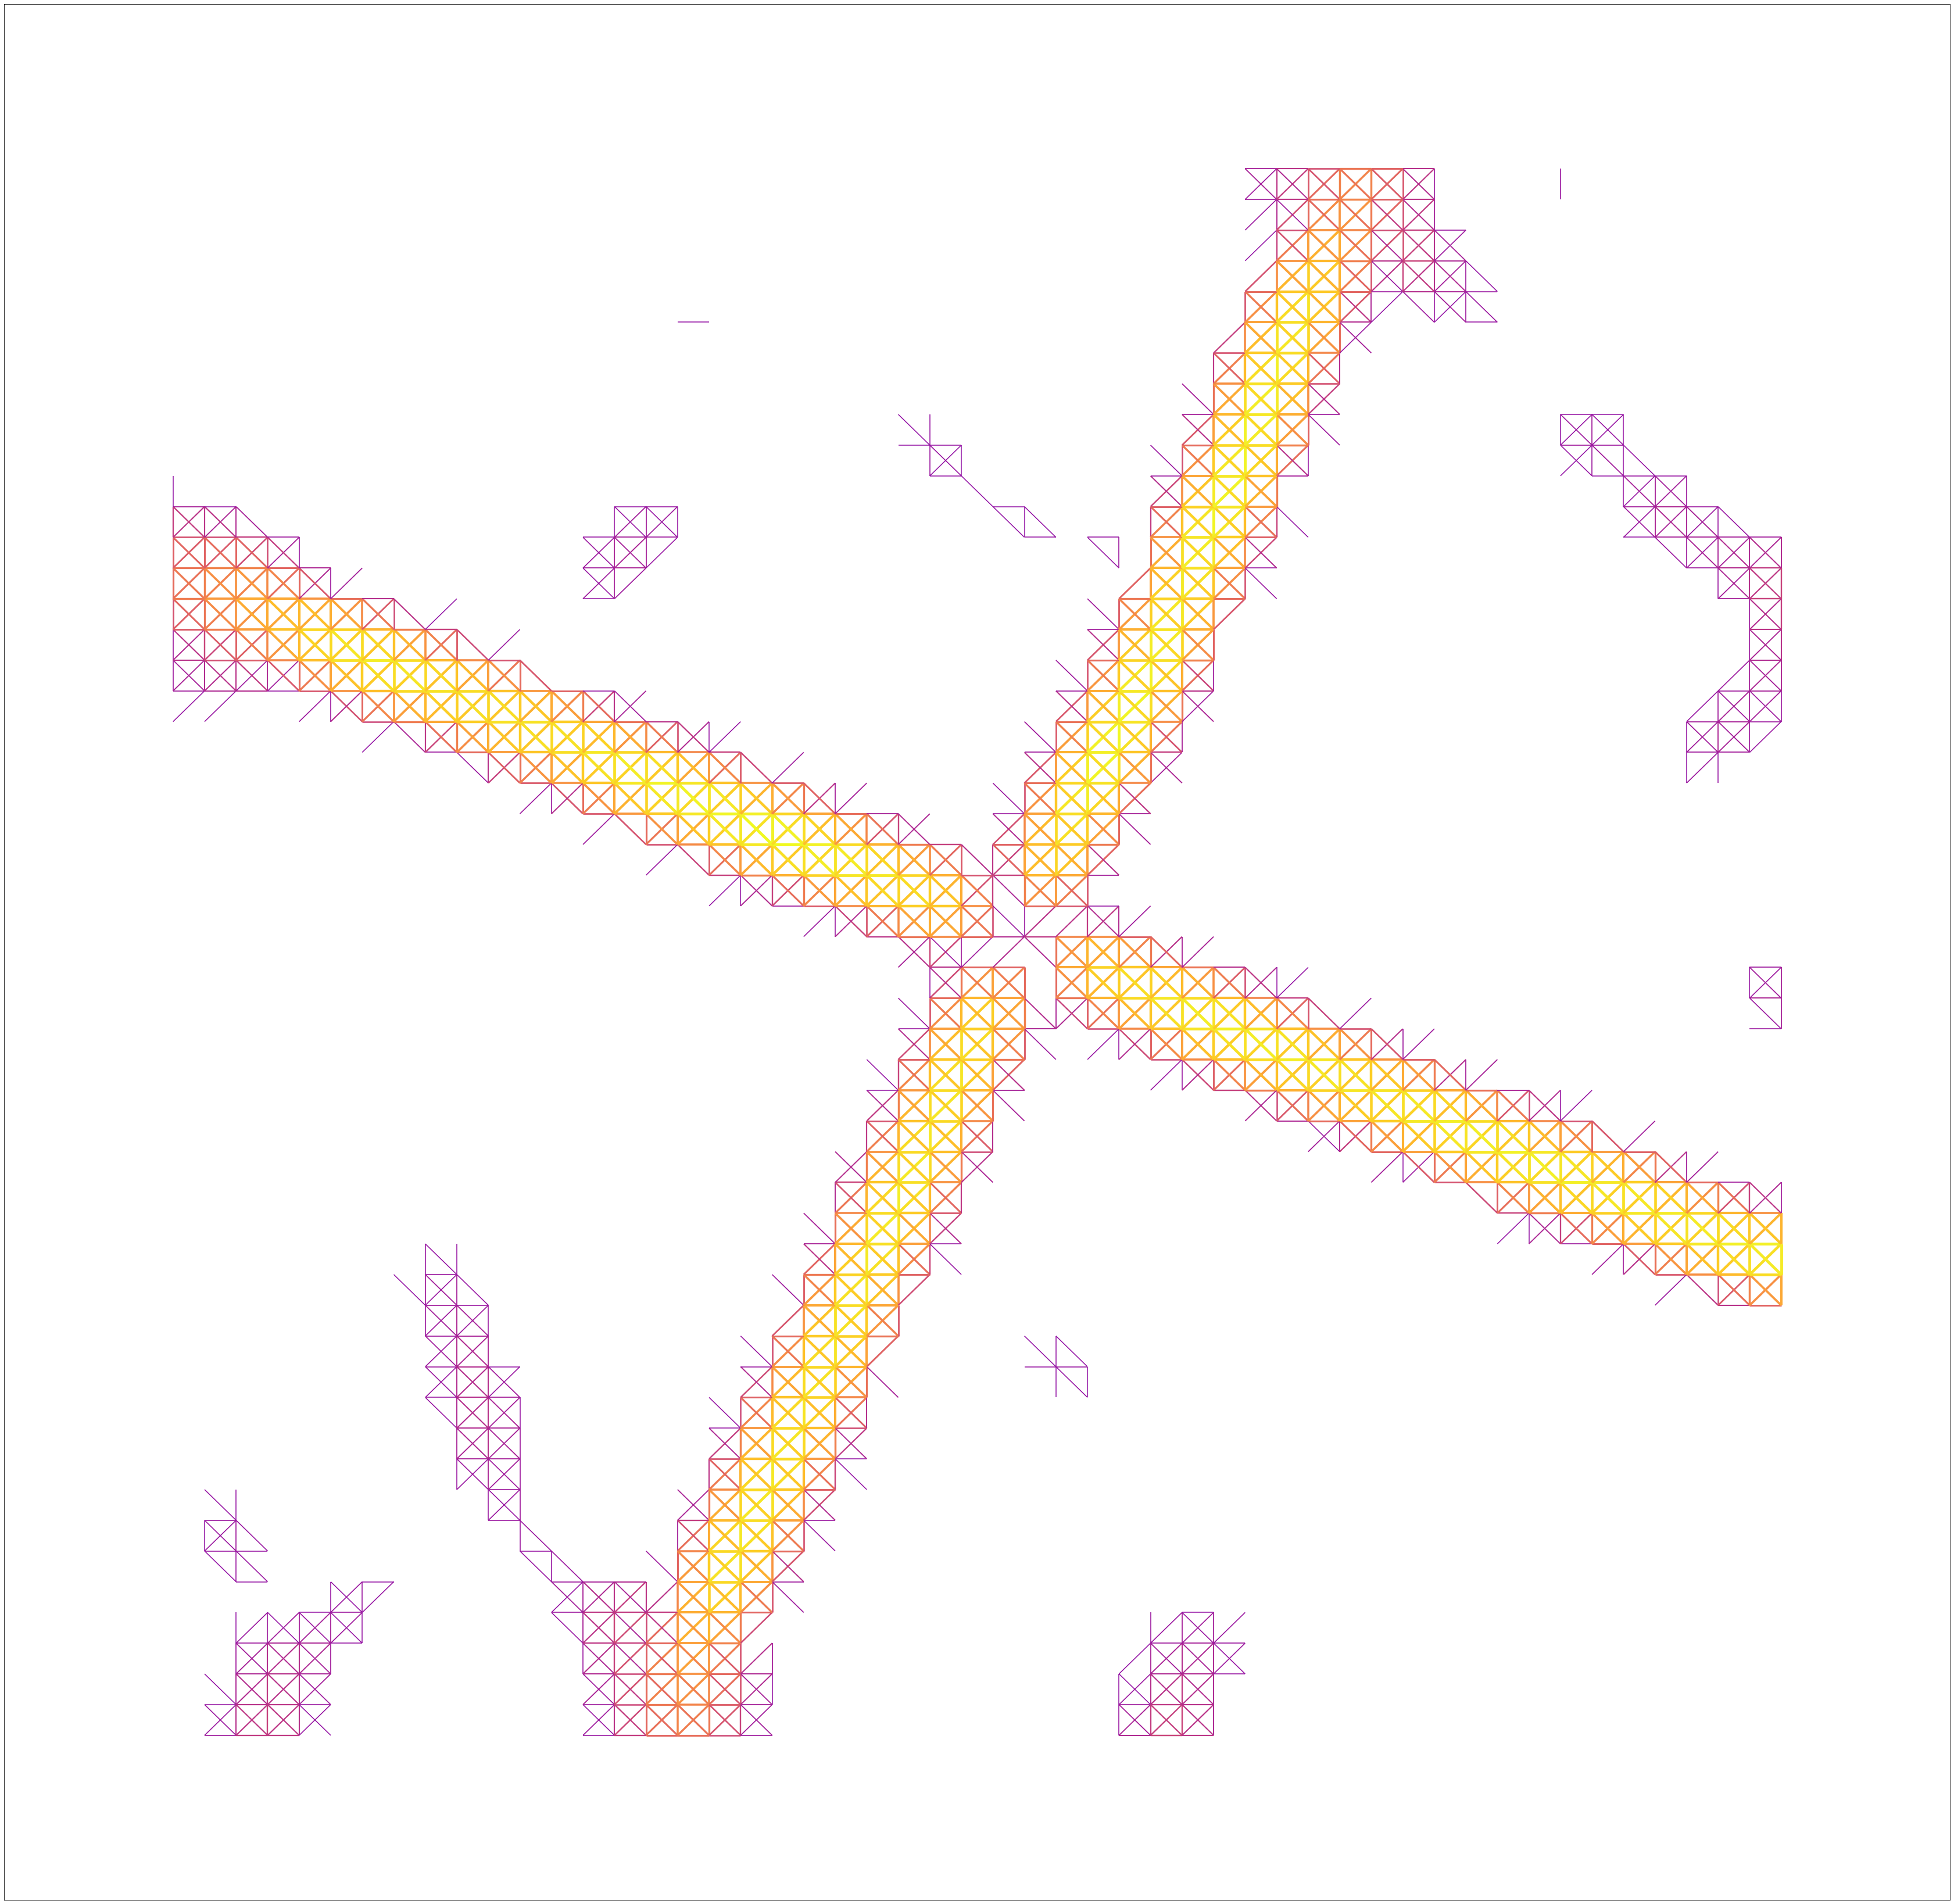

In [90]:
# %matplotlib notebook
plt.figure(figsize=(60, 60))
width = np.array([edgedata["weight"] for _, _, edgedata in G.edges(data=True)])
width = np.where(width < 0.3, np.zeros(width.shape), width)
edges = nx.draw_networkx_edges(G, nodes, width=width*5, edge_cmap = plt.cm.plasma, edge_color=width)
# plt.colorbar(edges)
# imshow(clean_img, cmap='gray', origin='lower')

In [86]:
[edgedata["weight"] for _, _, edgedata in G.edges(data=True)]

[0.21533114325381894,
 0.22841606953194632,
 0.21885790927804652,
 0.3399596067301016,
 0.22873643379306316,
 0.273518515033217,
 0.32535427539490475,
 0.32466523069717734,
 0.2440335788664533,
 0.3104979074095874,
 0.2944977961053847,
 0.25068356849631196,
 0.2844848897783294,
 0.4590869985986759,
 0.41751164351873854,
 0.44016861675473395,
 0.23959237934293784,
 0.2564598392508923,
 0.4449013862451359,
 0.4263175073014795,
 0.3068389518791037,
 0.38443498265474607,
 0.40106047572452047,
 0.45331270181426836,
 0.4791503380965079,
 0.4429295425632554,
 0.4436380366392859,
 0.43688905009167417,
 0.4077143620975143,
 0.4493670093806181,
 0.42653688201617085,
 0.2950332529393044,
 0.42151070278226155,
 0.31450345072272395,
 0.3063386479853271,
 0.32710271655775763,
 0.42859293451352065,
 0.42465866062157415,
 0.35501715856739574,
 0.10742702945359638,
 0.2378925853286615,
 0.10742702945359638,
 0.13048790599359011,
 0.13048790599359011,
 0.3414763089719138,
 0.29524623891600943,
 0.192290

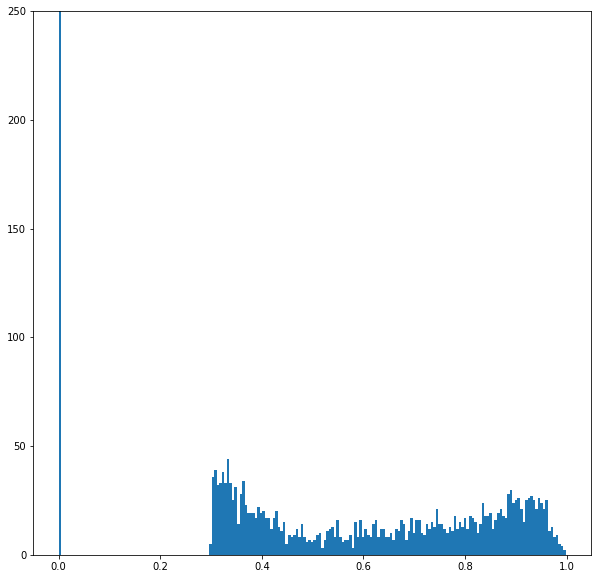

In [76]:
plt.figure(figsize=(10, 10))
# plt.scatter(np.arange(0, width.shape[0]), width)
plt.hist(width, bins=199)
plt.ylim((0, 250))
plt.show()

In [37]:
from skimage.filters import threshold_li, threshold_otsu

In [38]:
otsu, li = threshold_otsu(width), threshold_li(width)

/home/levtg/astro-morpho/venv/lib64/python3.10/site-packages/skimage/filters/thresholding.py:757: RuntimeWarning: divide by zero encountered in log
  / (np.log(mean_back) - np.log(mean_fore)))


# Построение графа узлов

В отличие от предыдущего пункта определяем узлы как места со слабыми связями рядом с сильными. Вес считается как косинусное растояние без учитывания длин векторов. (Можно откомментировать и будет как в пункте выше)

Слабыми считаются связи у которых вес ~0; т е угол между соседними векторами порядка 90

In [30]:
def weight_of(a, b):
    try:
        cos_dist = scipy.spatial.distance.cosine(a, b)
    except:
        cos_dist = 0
    return np.abs(1 - cos_dist) #* np.mean([np.linalg.norm(a), np.linalg.norm(b)])

In [31]:
Gn = nx.Graph()
nodes_n = {}
weights = []

In [32]:
for row in range(vectors.shape[0]):
    for col in range(vectors.shape[1]):
        cur = (row, col)
        cur_node = (x[cur], y[cur])
        nodes[cur_node] = cur_node
        Gn.add_node(cur_node, size=final_image[cur])
        for i in range(k_w):
            for j in range(k_h):
                pos = (np.clip(row + i - k_w//2, 0, U.shape[0] - 1), np.clip(col + j - k_h//2, 0, U.shape[1] - 1)) 
                pos_node = (x[pos], y[pos])
                if Gn.has_edge(cur_node, pos) or cur_node == pos_node:
                    continue
                weight = weight_of(vectors[cur], vectors[pos])
                weights.append(weight)
                nodes[pos_node] = pos_node
                Gn.add_edge(cur_node, pos_node, weight=weight)
                

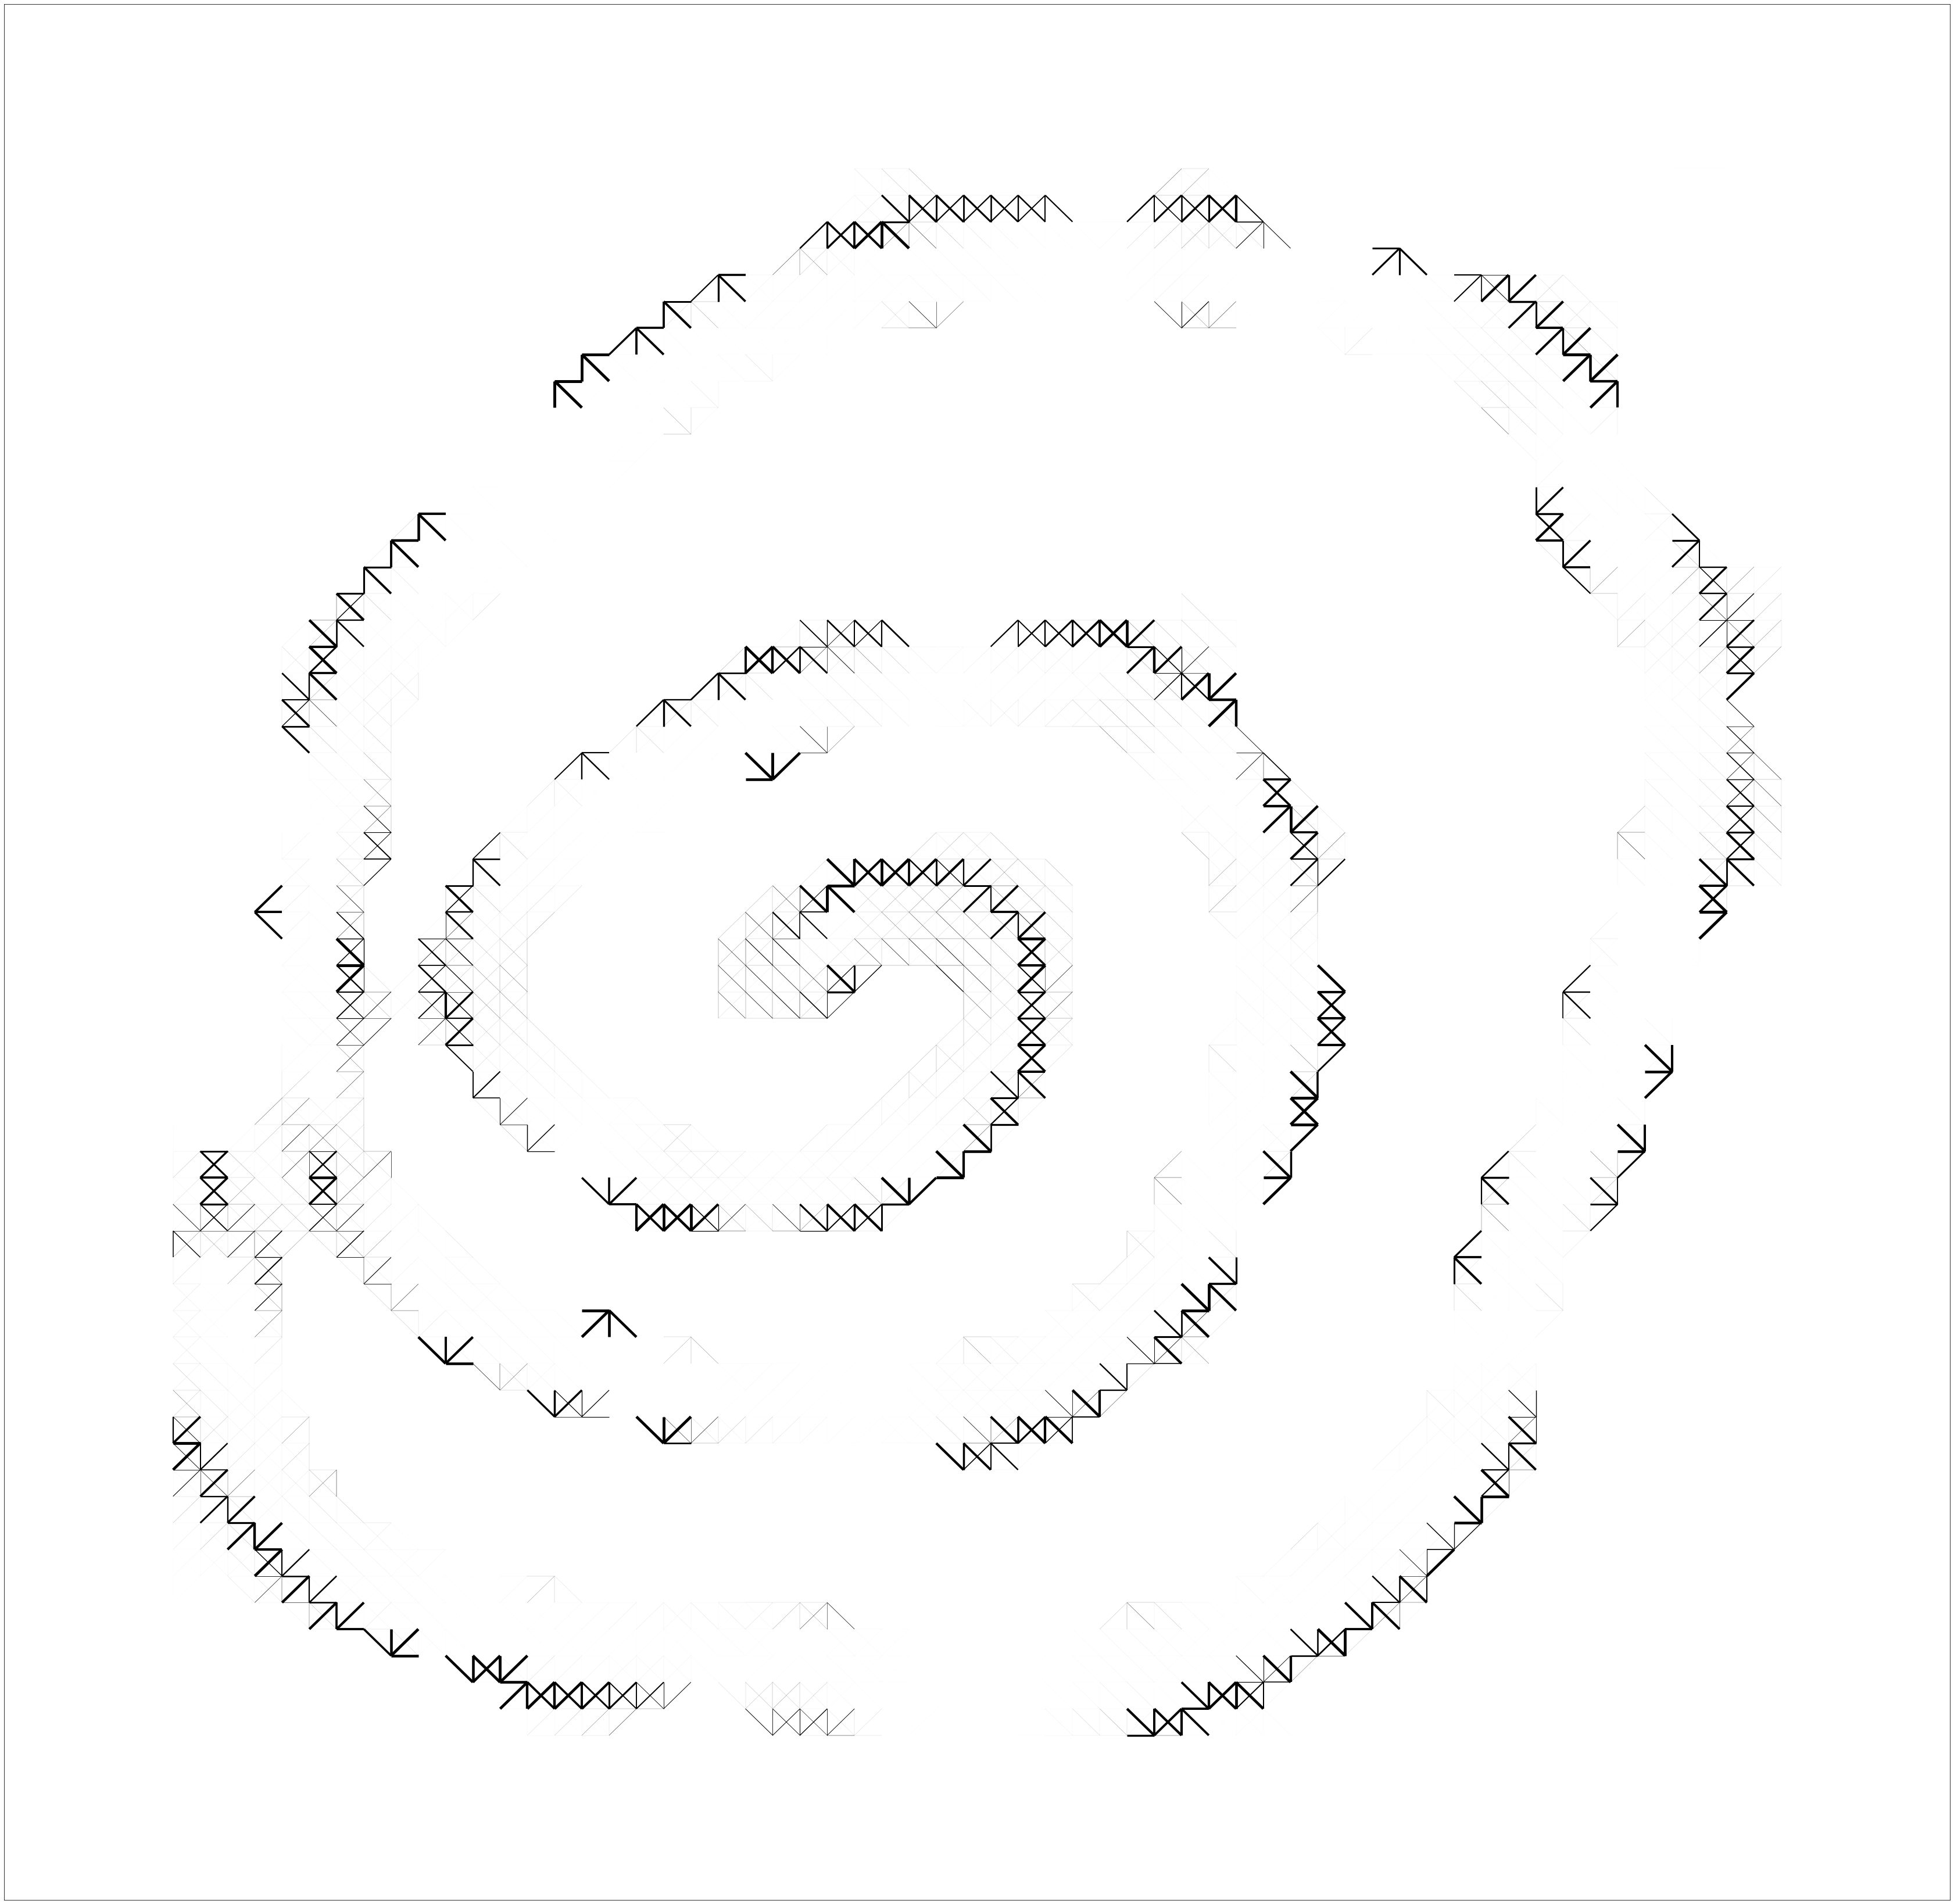

In [33]:
# %matplotlib notebook
plt.figure(figsize=(60, 60))
width = 1 - np.array([edgedata["weight"] for _, _, edgedata in Gn.edges(data=True)])
# width = np.where(width > -0.1, np.zeros(width.shape), width)
nx.draw_networkx_edges(Gn, nodes, width=width*5)
# imshow(clean_img, cmap='gray', origin='lower')

## Скелетонизация

Определение Сомы и её границ

Определение узлов/пересечений 

Определение центральной линии отростков последовательным перемещением по границе сомы и выделением самых ярких участков. Перемещение по вектору и снова поиск.
